In [1]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_addons as tfa
import os,cv2,random
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


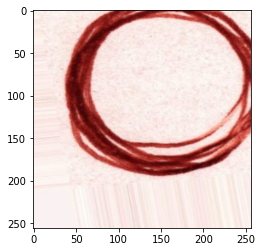

In [4]:
data_path = '/content/drive/MyDrive/PD/Circles/'
categories = ['CircleAugHeal', 'CircleAugPat']
for category in categories:
  path = os.path.join(data_path, category)
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path, img))
    new_array = cv2.resize(img_array, (256, 256))
    plt.imshow(new_array, cmap='gray')
    # plt.show()
    break
  break

In [5]:
IMG_SIZE = 64

training_set = []

for category in categories:
  path = os.path.join(data_path, category)
  index = categories.index(category)
  for img in os.listdir(path):
    try:
      img_array = cv2.imread(os.path.join(path, img))
      new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
      training_set.append([new_array, index])
    except Exception as e:
        pass

In [6]:
random.shuffle(training_set)

In [7]:
X_train = []
y_train = []

for img_array, label in training_set:
  X_train.append(img_array)
  y_train.append(label)

In [8]:
X_train =  np.array(X_train).reshape(-1,IMG_SIZE, IMG_SIZE, 3)
y_train = np.array(y_train)

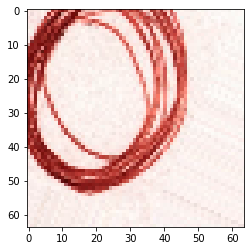

In [9]:
plt.imshow(X_train[0], cmap='gray')

In [10]:
X_train.shape

(2265, 64, 64, 3)

In [11]:
y_train[:5]

array([0, 0, 1, 1, 1])

In [12]:
y_train = y_train.reshape(-1,1)

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [14]:
num_classes = 2
input_shape = (64, 64, 3)

# (x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (1812, 64, 64, 3) - y_train shape: (1812, 1)
x_test shape: (453, 64, 64, 3) - y_test shape: (453, 1)


In [15]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 10
num_epochs = 50
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2

projection_dim = 64
num_heads = 4

transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [16]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        # layers.RandomZoom(
        #     height_factor=0.2, width_factor=0.2
        # ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [17]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [18]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


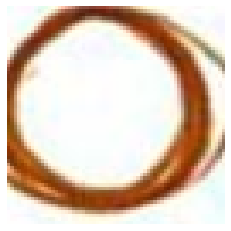

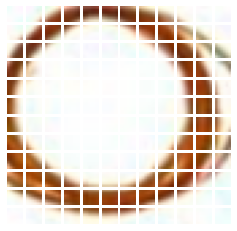

In [19]:
plt.figure(figsize=(4, 4))
image = x_train[0]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [20]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [21]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [22]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            # keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/50
163/163 [==============================] - 143s 778ms/step - loss: 2.9681 - accuracy: 0.6816 - val_loss: 0.6694 - val_accuracy: 0.6593
Epoch 2/50
163/163 [==============================] - 126s 773ms/step - loss: 0.5797 - accuracy: 0.7429 - val_loss: 0.3810 - val_accuracy: 0.7967
Epoch 3/50
163/163 [==============================] - 122s 748ms/step - loss: 0.4362 - accuracy: 0.7828 - val_loss: 0.4241 - val_accuracy: 0.7747
Epoch 4/50
163/163 [==============================] - 123s 753ms/step - loss: 0.4069 - accuracy: 0.8092 - val_loss: 0.3061 - val_accuracy: 0.8681
Epoch 5/50
163/163 [==============================] - 129s 794ms/step - loss: 0.3980 - accuracy: 0.8110 - val_loss: 0.3442 - val_accuracy: 0.8516
Epoch 6/50
163/163 [==============================] - 124s 759ms/step - loss: 0.3801 - accuracy: 0.8215 - val_loss: 0.2921 - val_accuracy: 0.8681
Epoch 7/50
163/163 [==============================] - 129s 793ms/step - loss: 0.3790 - accuracy: 0.8160 - val_loss: 0.3045 -